In [86]:
import os
try:
    print(file_path)
except:
    file_path = os.path.abspath('')
    os.chdir(os.path.dirname(file_path))
    print(file_path)

d:\Project\face-recogtion-mlops\notebook


# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [87]:
# System libraries
import os
import random
import requests
from tqdm import tqdm
from PIL import Image

# Data analytics and visualisations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# PyTorch packages
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from torchinfo import summary
from torchvision import transforms as T
from src.Utils.utils import *
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training

import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from src.siamese_triplet.trainer import fit
cuda = torch.cuda.is_available()

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from  torchvision.transforms import InterpolationMode 
from torchvision.transforms import v2
from torchvision import datasets


# Set up data loaders
from src.siamese_triplet.datasets import TripletMNIST
from src.siamese_triplet.networks import EmbeddingNet, TripletNet
from src.siamese_triplet.losses import TripletLoss

In [88]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [89]:

data_dir = 'data/facenet_vn_cropped'
facenet_config_path = 'config/facenet.yaml'
facenet_config = read_config(path = facenet_config_path)
EPOCHS = facenet_config['EPOCHS']
PATIENCE = facenet_config['PATIENCE']
BATCH_SIZE = facenet_config['BATCH_SIZE']
learning_rate = facenet_config['learning_rate']
IMG_SIZE = facenet_config['IMG_SIZE']
RANDOM_SEED = facenet_config['RANDOM_SEED']
WEIGHT_DECAY = facenet_config['WEIGHT_DECAY']
LR_WARMUP = facenet_config['LR_WARMUP']
CLIP_GRAD_NORM = facenet_config['CLIP_GRAD_NORM']
PRETRAINED_MODEL = facenet_config['PRETRAINED_MODEL']
MODEL_DIR = facenet_config['MODEL_DIR']
MODEL_DIR = rename_model(model_dir = MODEL_DIR, prefix='facenet')
facenet_config['MODEL_DIR'] = MODEL_DIR
NUM_WORKERS = 0 if os.name == 'nt' else 8


In [90]:
data_dir="data/facenet_vn_cropped"

In [91]:
mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10


In [92]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [93]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

In [94]:
images, target = next(enumerate(train_loader))

In [95]:
images

0

In [102]:
target[0].shape

torch.Size([4, 1, 28, 28])

In [8]:
train_folders, test_folders = torch.utils.data.random_split(
    sorted(os.listdir(f"{data_dir}")), [0.9, 0.1]
)
print(len(train_folders), len(test_folders))

802 89


In [9]:
transform_original = v2.Compose([
    v2.Resize(160, interpolation=InterpolationMode.BICUBIC,),
    v2.CenterCrop(160),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_face_dataset = datasets.ImageFolder(data_dir, transform=transform_original)
test_face_dataset = datasets.ImageFolder("data/facenet_vn_cropped_test", transform=transform_original)
train_face_dataset.train =True


d:\Project\face-recogtion-mlops\.venv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [10]:
train_face_dataset

Dataset ImageFolder
    Number of datapoints: 4526
    Root location: data/facenet_vn_cropped
    StandardTransform
Transform: Compose(
                 Resize(size=[160], interpolation=InterpolationMode.BICUBIC, antialias=True)
                 CenterCrop(size=(160, 160))
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [11]:
test_face_dataset

Dataset ImageFolder
    Number of datapoints: 110
    Root location: data/facenet_vn_cropped_test
    StandardTransform
Transform: Compose(
                 Resize(size=[160], interpolation=InterpolationMode.BICUBIC, antialias=True)
                 CenterCrop(size=(160, 160))
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

## Common setup

In [66]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [13]:
train_dataset.train_labels

d:\Project\face-recogtion-mlops\.venv\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

In [14]:
triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images

d:\Project\face-recogtion-mlops\.venv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [15]:
class TripletFace(Dataset):
    """
    Train: For each sample (anchor), randomly chooses a positive and negative sample.
    Test: Creates fixed triplets for testing.
    """

    def __init__(self, image_folder_dataset, train=True):
        self.image_folder_dataset = image_folder_dataset
        self.train = train
        self.transform = self.image_folder_dataset.transform

        # Split dataset into train and test
        if self.train:
            self.data = [self.image_folder_dataset.samples[i][0] for i in range(len(self.image_folder_dataset))]
            self.labels = [self.image_folder_dataset.samples[i][1] for i in range(len(self.image_folder_dataset))]
            self.labels_set = set(self.labels)
            self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                     for label in self.labels_set}
        else:
            self.data = [self.image_folder_dataset.samples[i][0] for i in range(len(self.image_folder_dataset))]
            self.labels = [self.image_folder_dataset.samples[i][1] for i in range(len(self.image_folder_dataset))]
            self.labels_set = set(self.labels)
            self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.labels[i]]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.labels[i]]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1_path, label1 = self.data[index], self.labels[index]
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])

            img2_path = self.data[positive_index]
            img3_path = self.data[negative_index]
        else:
            img1_path = self.data[self.test_triplets[index][0]]
            img2_path = self.data[self.test_triplets[index][1]]
            img3_path = self.data[self.test_triplets[index][2]]

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        img3 = Image.open(img3_path).convert('RGB')
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return (img1, img2, img3), []

    def __len__(self):
        return len(self.image_folder_dataset)

In [16]:
def plot_triplet(images):
    # Plot the images
    fig, ax = plt.subplots(1, 3)
    labels = ["Anchor", "Positive", "Negative"]
    for i, img in enumerate(images):
        print(img.shape)
        # The shape of the image is changed to (3, 112, 112),
        # for plotting, we need the shape to be (112, 112, 3)
        ax[i].imshow(img.permute(1,2,0))

        # Hide the ticks
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        # Add a label
        ax[i].set_title(labels[i])

In [17]:
# Create an EmbeddingNet class for Facenet
class FacenetEmbeddingNet(nn.Module):
    def __init__(self, facenet_model):
        super(FacenetEmbeddingNet, self).__init__()
        self.facenet_model = facenet_model

    def forward(self, x):
        # Forward pass through Facenet model
        return self.facenet_model(x)

    def get_embedding(self, x):
        # Get embeddings using the Facenet model
        return self.facenet_model(x)

# Example usage:
# Assuming 'device' is defined and set appropriately
res_model = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes=None, device=device)
facenet_embedding_net = FacenetEmbeddingNet(res_model)
facenet_model = TripletNet(facenet_embedding_net)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


torch.Size([3, 160, 160])
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])


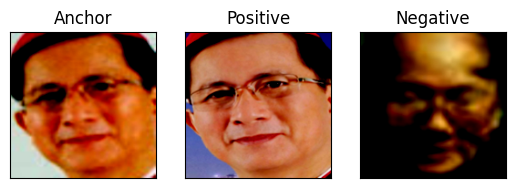

In [18]:
triplet_train_face_dataset = TripletFace(train_face_dataset) # Returns triplets of images
triplet_test_face_dataset = TripletFace(test_face_dataset) # Returns triplets of images
plot_triplet(triplet_train_face_dataset[100][0])

In [19]:
batch_size = 32
kwargs = {'num_workers': NUM_WORKERS, 'pin_memory': True} if cuda else {}
triplet_train_face_loader = torch.utils.data.DataLoader(triplet_train_face_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_face_loader = torch.utils.data.DataLoader(triplet_test_face_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 1.
if cuda:
    facenet_model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(facenet_model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 1
log_interval = 10

In [128]:
fit(triplet_train_face_loader, triplet_test_face_loader, facenet_model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/4526 (0%)]	Loss: 0.354864
Train: [320/4526 (7%)]	Loss: 0.404152
Train: [640/4526 (14%)]	Loss: 0.374867
Train: [960/4526 (21%)]	Loss: 0.455473
Train: [1280/4526 (28%)]	Loss: 0.437955
Train: [1600/4526 (35%)]	Loss: 0.415324
Train: [1920/4526 (42%)]	Loss: 0.421107
Train: [2240/4526 (49%)]	Loss: 0.395676
Train: [2560/4526 (56%)]	Loss: 0.382013
Train: [2880/4526 (63%)]	Loss: 0.410039
Train: [3200/4526 (70%)]	Loss: 0.377895
Train: [3520/4526 (77%)]	Loss: 0.463846
Train: [3840/4526 (85%)]	Loss: 0.323141
Train: [4160/4526 (92%)]	Loss: 0.447706
Train: [4480/4526 (99%)]	Loss: 0.367589
Epoch: 1/1. Train set: Average loss: 0.4028
Epoch: 1/1. Validation set: Average loss: 0.3716


In [131]:
torch.save(facenet_model.state_dict(), "models/facenet_tune/facenet.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.4666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping 

torch.Size([32, 512]) torch.Size([32, 512])
tensor([0.2116, 1.6166, 0.7881, 0.1660, 0.4479, 0.2011, 0.0342, 0.8140, 0.9226,
        2.5861, 0.0367, 0.5526, 0.8567, 2.5842, 0.6630, 1.6528, 0.7528, 2.1066,
        0.4553, 0.4176, 0.0591, 0.3410, 0.0236, 2.0215, 0.0186, 2.4128, 1.7649,
        0.0908, 2.0252, 0.1829, 0.6057, 1.7753], device='cuda:0') tensor([2.2866, 1.8777, 2.9641, 0.5226, 3.0583, 0.1902, 2.7485, 3.2904, 1.0545,
        2.8515, 3.3375, 2.0692, 2.9213, 2.2071, 3.1006, 0.9094, 2.0674, 0.8764,
        2.9585, 2.2147, 0.9656, 3.1475, 1.6001, 3.1131, 2.4353, 1.4194, 1.3960,
        1.3592, 0.7484, 2.1699, 2.0050, 3.1903], device='cuda:0')
torch.Size([32]) torch.Size([32])


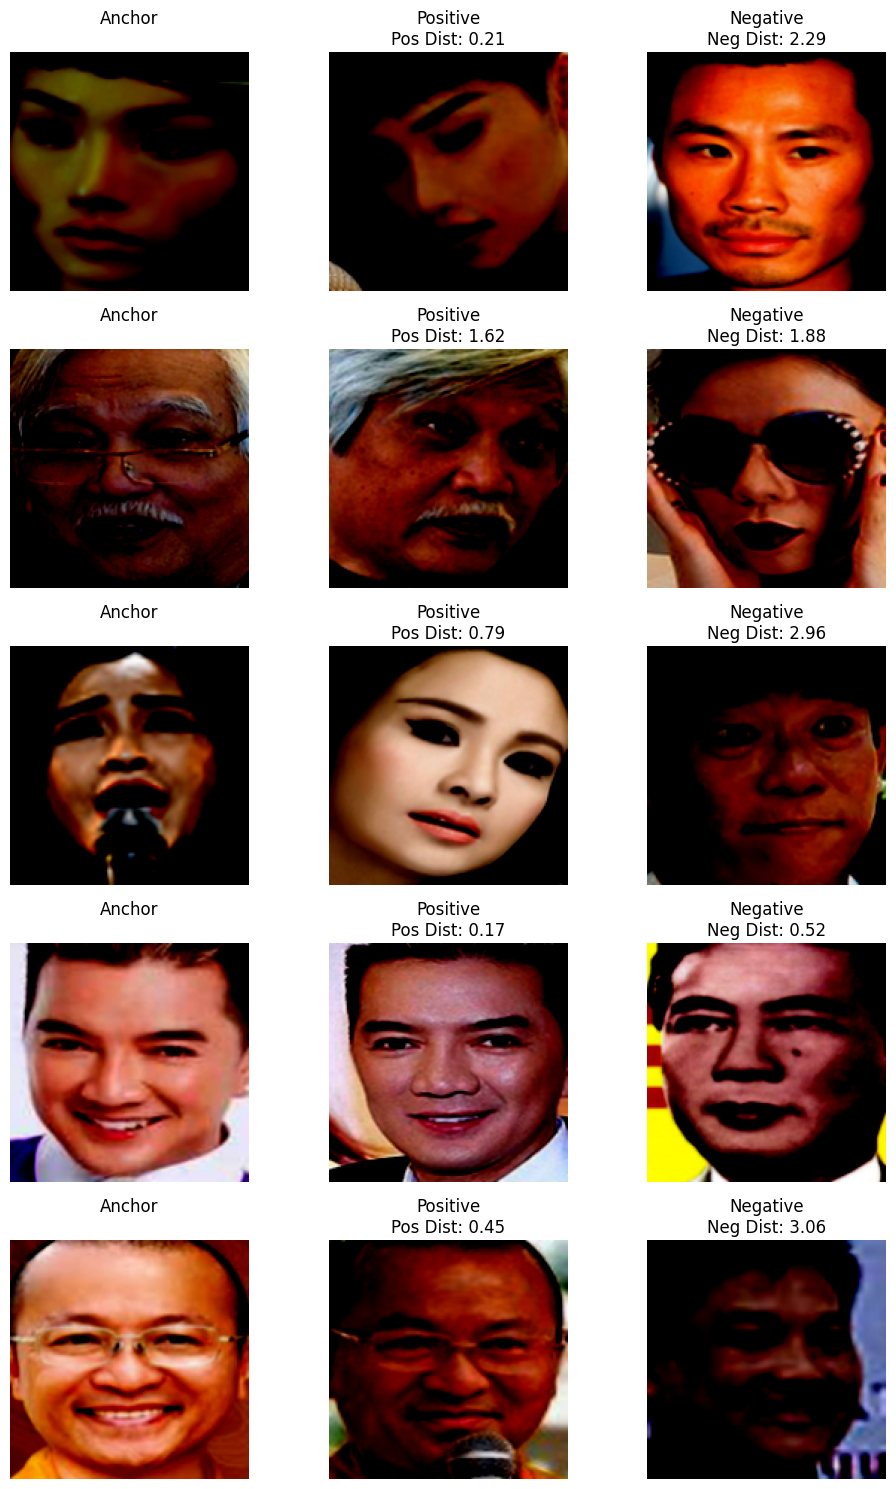

In [133]:
# Assume model and val_loader are defined elsewhere

i, ((a, p, n),_) = next(enumerate(triplet_train_face_loader))  # [random.randint(0, len(val_set) - 1)]
a, p, n = a.to(device), p.to(device), n.to(device)
facenet_model.eval()

with torch.inference_mode():
    a_out , p_out, n_out = facenet_model.forward(a, p, n)
    print(p_out.shape, n_out.shape)
    distance_positive = (a_out - p_out).pow(2).sum(1)  # .pow(.5)
    distance_negative = (a_out - n_out).pow(2).sum(1)  # .pow(.5)
    print(distance_positive, distance_negative)
    print(distance_positive.shape, distance_negative.shape)



# Number of pairs to plot
num_pairs = 5

# Ensure we have at least 5 pairs
num_pairs = min(num_pairs, len(a))

fig, axes = plt.subplots(num_pairs, 3, figsize=(10, 3 * num_pairs))

for i in range(num_pairs):
    ax = axes[i]
    sample_idx = i
    
    anchor_img = a[sample_idx].cpu().permute(1, 2, 0).numpy()
    positive_img = p[sample_idx].cpu().permute(1, 2, 0).numpy()
    negative_img = n[sample_idx].cpu().permute(1, 2, 0).numpy()
    
    distance_pos = distance_positive[sample_idx].item()
    distance_neg = distance_negative[sample_idx].item()

    # Plot Anchor Image
    ax[0].imshow(anchor_img)
    ax[0].set_title(f'Anchor\n')
    ax[0].axis('off')

    # Plot Positive Image
    ax[1].imshow(positive_img)
    ax[1].set_title(f'Positive\nPos Dist: {distance_pos:.2f}')
    ax[1].axis('off')

    # Plot Negative Image
    ax[2].imshow(negative_img)
    ax[2].set_title(f'Negative\nNeg Dist: {distance_neg:.2f}')
    ax[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 32
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

d:\Project\face-recogtion-mlops\.venv\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
d:\Project\face-recogtion-mlops\.venv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
d:\Project\face-recogtion-mlops\.venv\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
d:\Project\face-recogtion-mlops\.venv\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


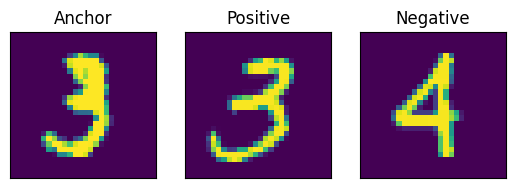

In [ ]:
plot_triplet(triplet_train_dataset[10][0])

In [ ]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

d:\Project\face-recogtion-mlops\.venv\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/60000 (0%)]	Loss: 0.999695
Train: [3200/60000 (5%)]	Loss: 0.423786
Train: [6400/60000 (11%)]	Loss: 0.244566
Train: [9600/60000 (16%)]	Loss: 0.203453
Train: [12800/60000 (21%)]	Loss: 0.189632


KeyboardInterrupt: 

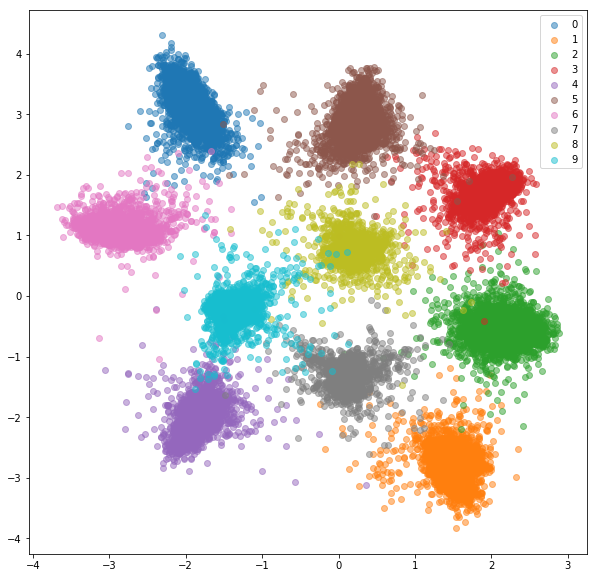

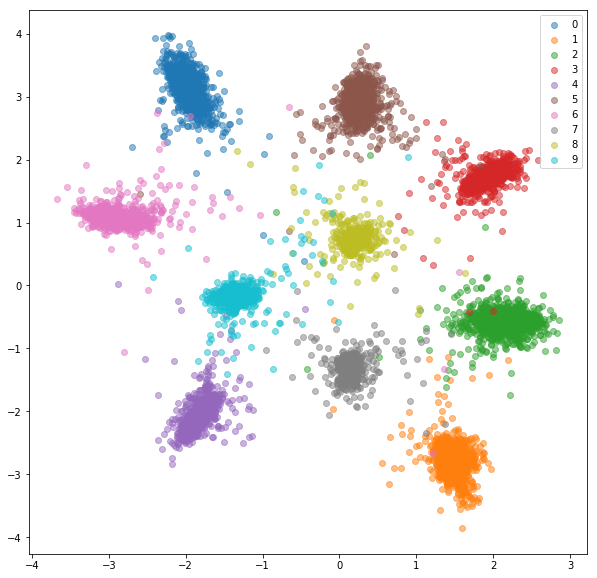

In [ ]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.491550
Train: [12500/60000 (21%)]	Loss: 0.270060
Train: [25000/60000 (42%)]	Loss: 0.139297
Train: [37500/60000 (62%)]	Loss: 0.096533
Train: [50000/60000 (83%)]	Loss: 0.076680
Epoch: 1/20. Train set: Average loss: 0.1338
Epoch: 1/20. Validation set: Average loss: 0.0537
Train: [0/60000 (0%)]	Loss: 0.052101
Train: [12500/60000 (21%)]	Loss: 0.052579
Train: [25000/60000 (42%)]	Loss: 0.047850
Train: [37500/60000 (62%)]	Loss: 0.037767
Train: [50000/60000 (83%)]	Loss: 0.037061
Epoch: 2/20. Train set: Average loss: 0.0418
Epoch: 2/20. Validation set: Average loss: 0.0325
Train: [0/60000 (0%)]	Loss: 0.015191
Train: [12500/60000 (21%)]	Loss: 0.027951
Train: [25000/60000 (42%)]	Loss: 0.025129
Train: [37500/60000 (62%)]	Loss: 0.026858
Train: [50000/60000 (83%)]	Loss: 0.024246
Epoch: 3/20. Train set: Average loss: 0.0254
Epoch: 3/20. Validation set: Average loss: 0.0274
Train: [0/60000 (0%)]	Loss: 0.010963
Train: [12500/60000 (21%)]	Loss: 0.019170
Train: [25000/60000 (

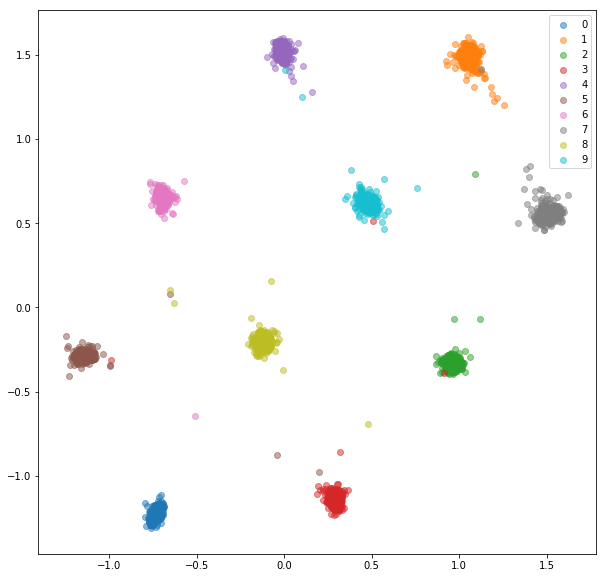

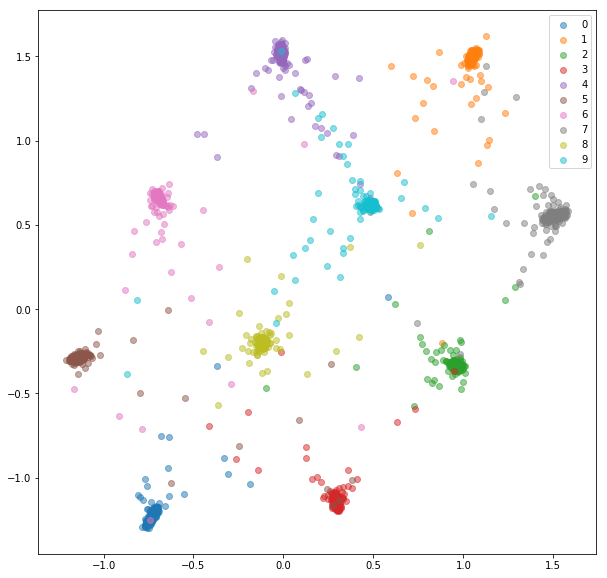

In [ ]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999806	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.989613	Average nonzero triplets: 2648.725490196078
Train: [25000/60000 (42%)]	Loss: 0.994085	Average nonzero triplets: 2328.5346534653463
Train: [37500/60000 (62%)]	Loss: 0.958655	Average nonzero triplets: 2115.5165562913908
Train: [50000/60000 (83%)]	Loss: 0.976330	Average nonzero triplets: 1921.4925373134329
Epoch: 1/20. Train set: Average loss: 0.9805	Average nonzero triplets: 1801.7071129707113
Epoch: 1/20. Validation set: Average loss: 0.8326	Average nonzero triplets: 1218.6410256410256
Train: [0/60000 (0%)]	Loss: 0.876484	Average nonzero triplets: 1217.0
Train: [12500/60000 (21%)]	Loss: 0.991039	Average nonzero triplets: 975.3529411764706
Train: [25000/60000 (42%)]	Loss: 0.992353	Average nonzero triplets: 934.009900990099
Train: [37500/60000 (62%)]	Loss: 1.075175	Average nonzero triplets: 917.0596026490066
Train: [50000/60000 (83%)]	Loss: 1.023091	Average nonzero triplets: 889

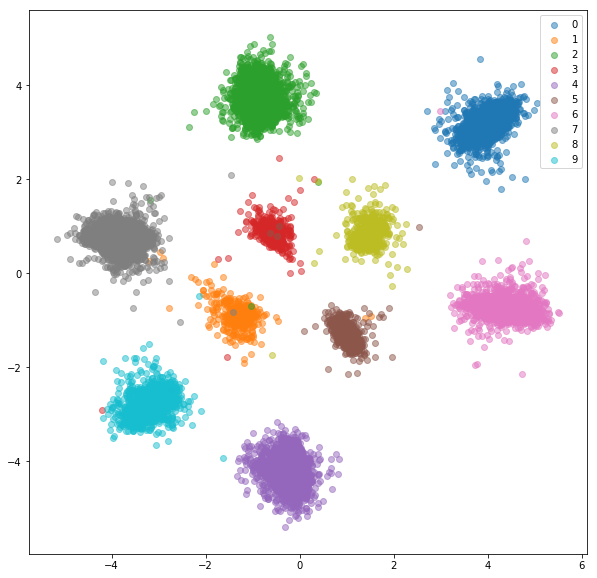

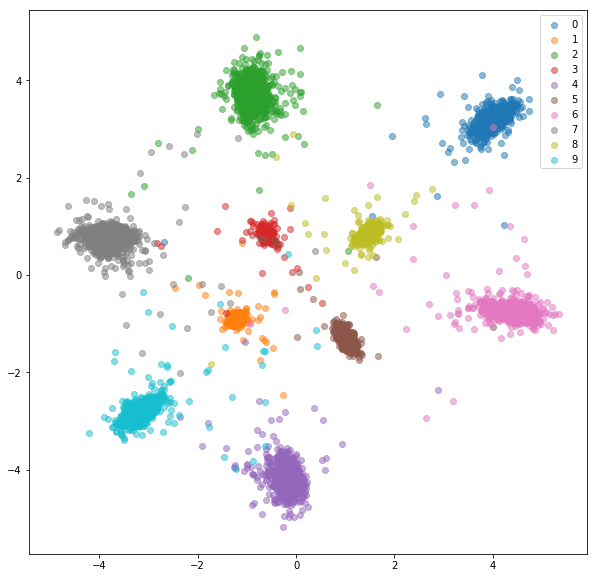

In [ ]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

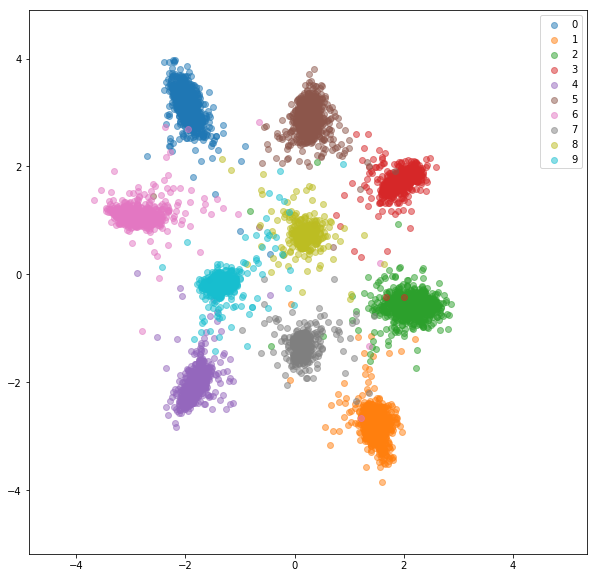

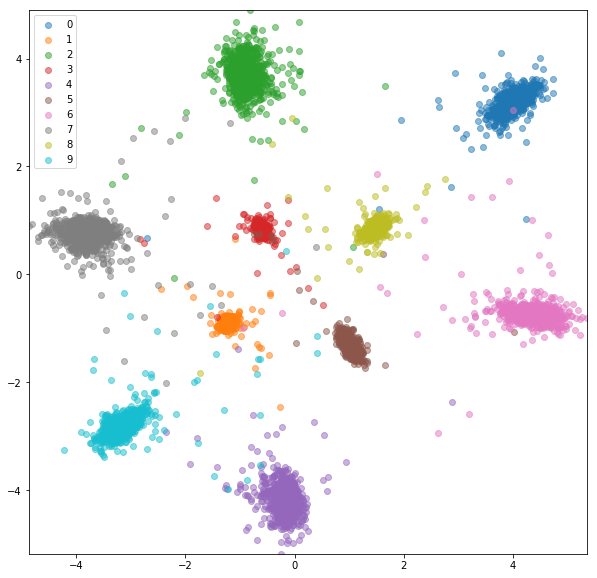

In [ ]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

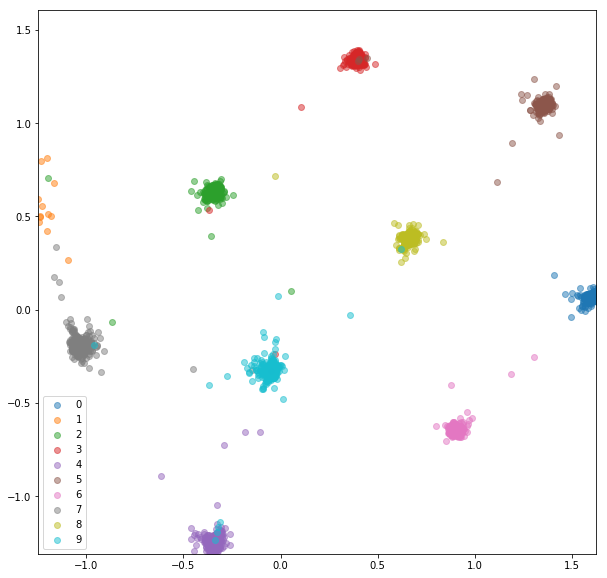

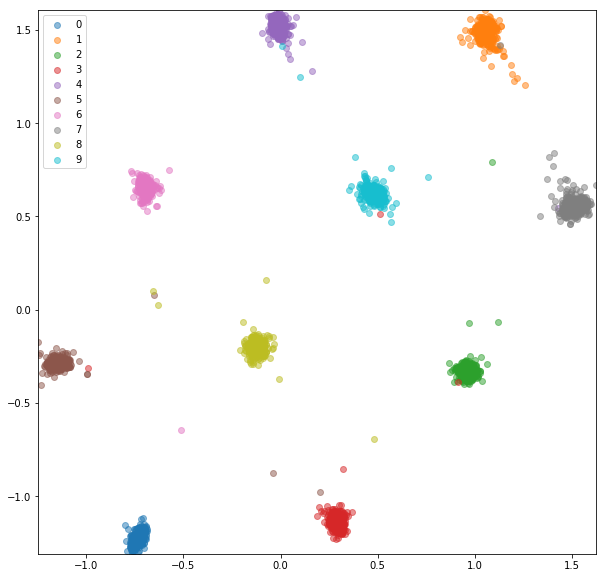

In [ ]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)